loading annotations into memory...
Done (t=0.90s)
creating index...
index created!
Total images in dataset: 5000


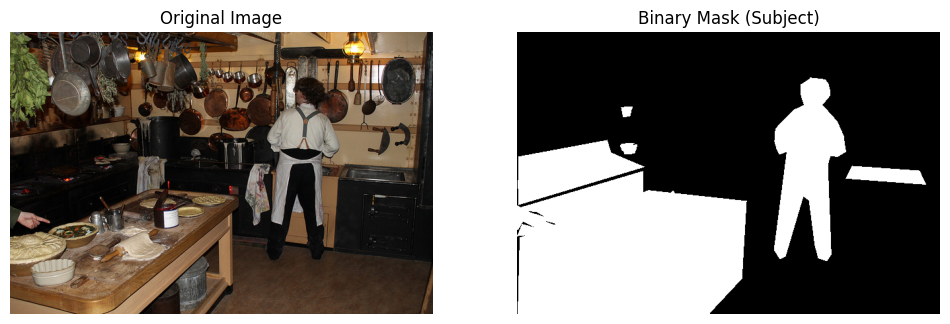

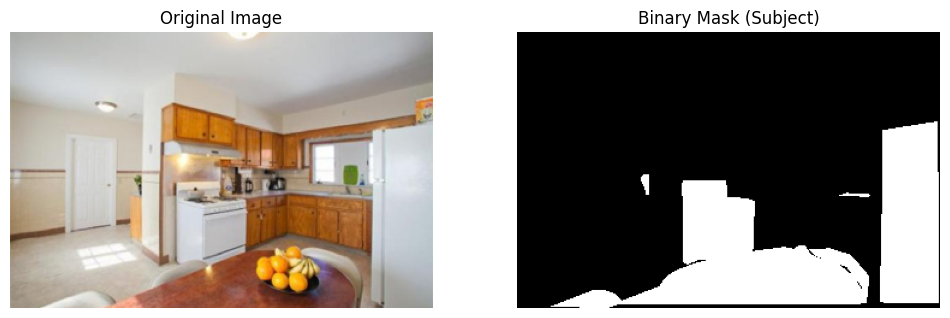

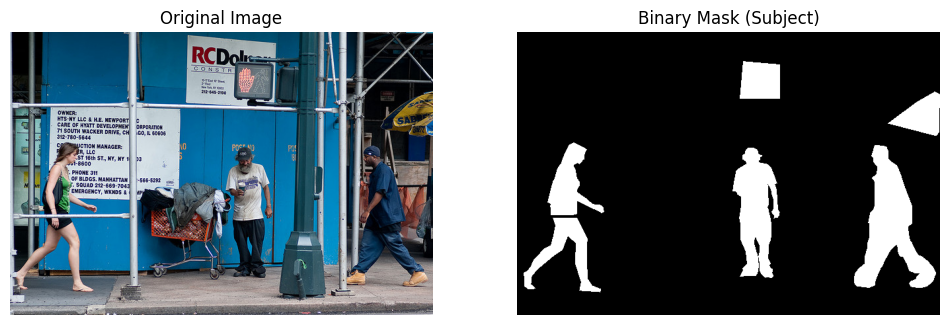

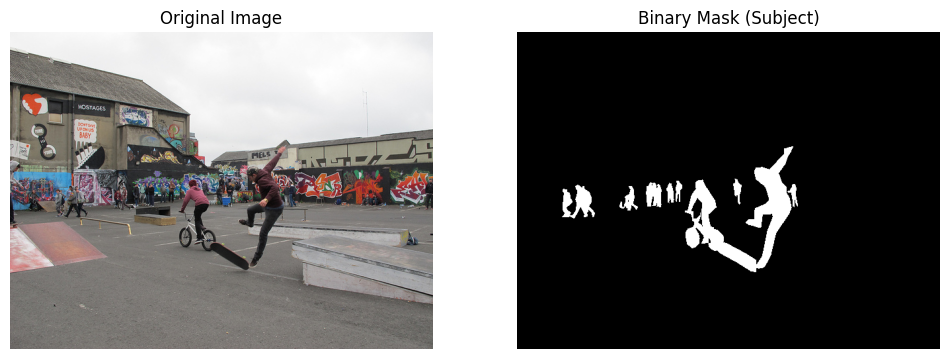

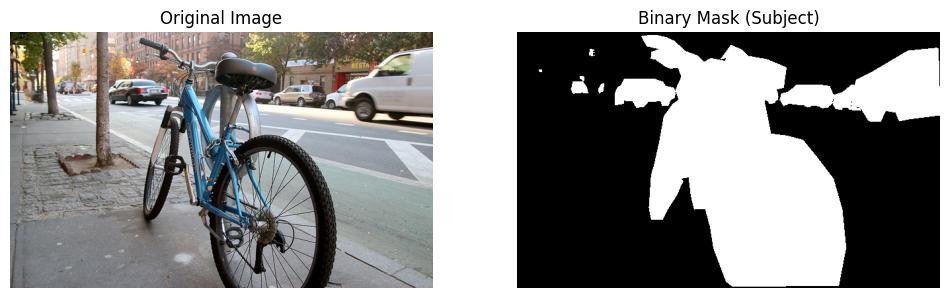

In [ ]:
#Week 1

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pycocotools.coco import COCO
from tensorflow.keras.preprocessing.image import ImageDataGenerator


DATA_ROOT = "/content/drive/MyDrive/VisionAI"
IMAGES_DIR = os.path.join(DATA_ROOT, "val2017")  # or train2017
ANN_FILE = os.path.join(DATA_ROOT, "annotations", "instances_val2017.json")

coco = COCO(ANN_FILE)
img_ids = coco.getImgIds()
print("Total images in dataset:", len(img_ids))

def build_binary_mask(coco, img_info):
    # Get all annotations for this image
    ann_ids = coco.getAnnIds(imgIds=img_info['id'], iscrowd=False)
    anns = coco.loadAnns(ann_ids)

    # Empty mask
    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

    # Add each object’s mask
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))

    # Convert to binary: 0 = background, 1 = subject
    mask = np.clip(mask, 0, 1)
    return mask

for img_id in img_ids[:5]:
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(IMAGES_DIR, img_info['file_name'])

    img = cv2.imread(img_path)
    if img is None:
        print("Image missing:", img_path)
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = build_binary_mask(coco, img_info)

    plt.figure(figsize=(12,6))

    # Original image
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    # Binary mask
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap="gray")
    plt.title("Binary Mask (Subject)")
    plt.axis("off")

    plt.show()

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!
Total images: 5000


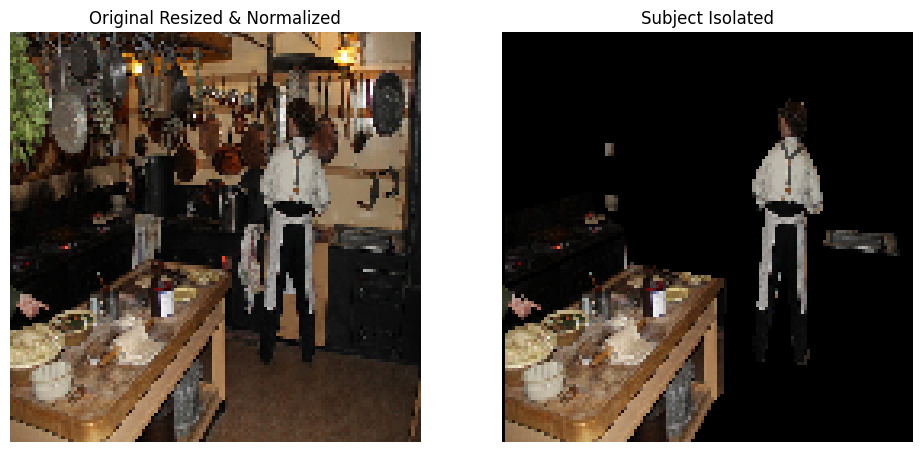

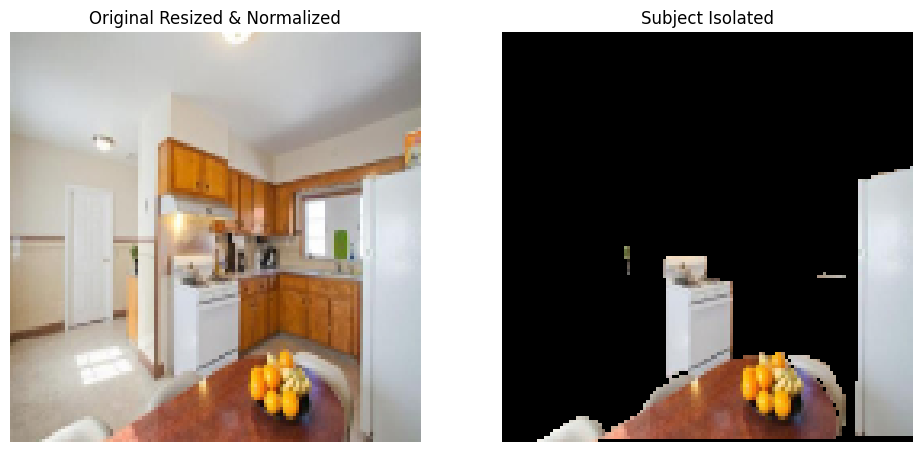

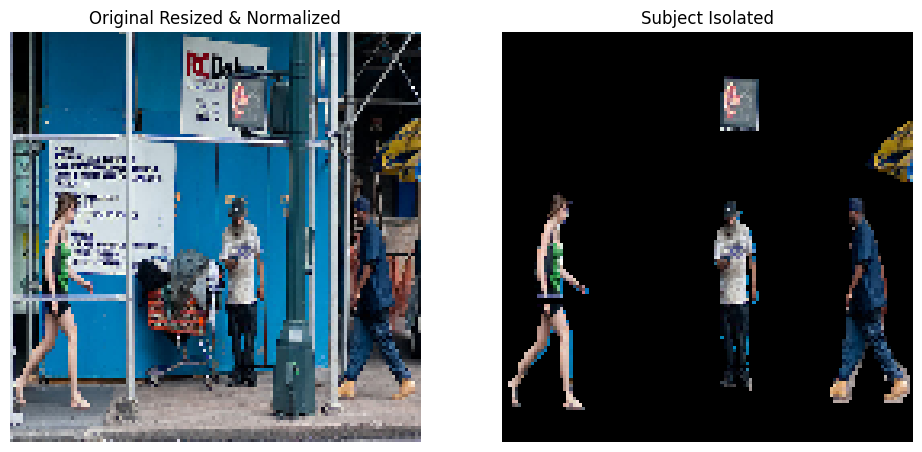

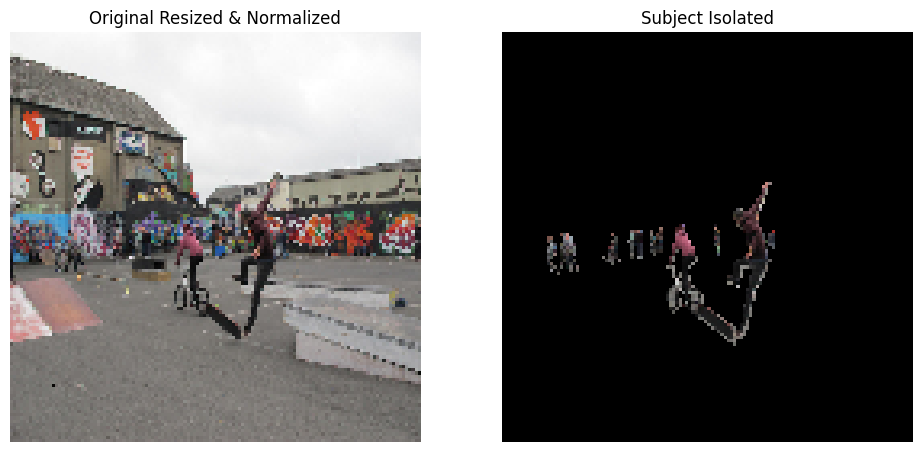

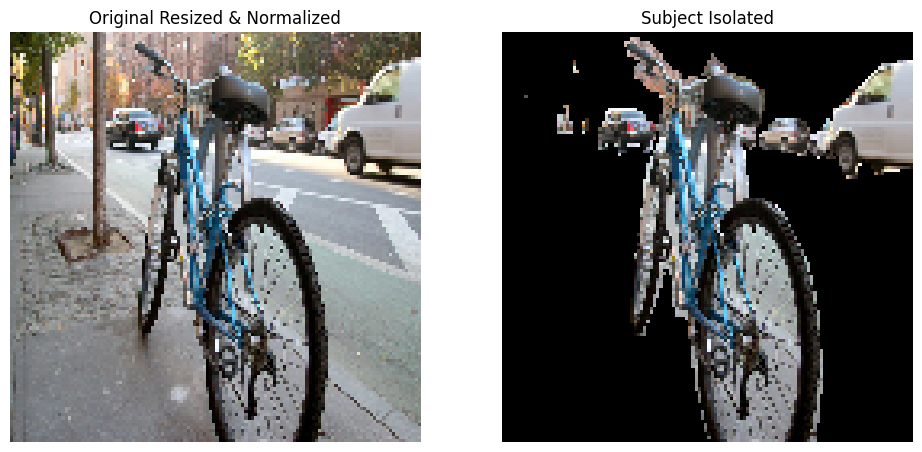

In [ ]:
# ==============================
# WEEK 2: PREPROCESSING PIPELINE (Corrected Augmentation)
# ==============================

# Step 1: Import Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pycocotools.coco import COCO
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ==============================
# Step 2: Set Dataset Paths
# ==============================
DATA_ROOT = "/content/drive/MyDrive/VisionAI"  # Update your path
IMAGES_DIR = os.path.join(DATA_ROOT, "val2017")  # or train2017
ANN_FILE = os.path.join(DATA_ROOT, "annotations", "instances_val2017.json")

coco = COCO(ANN_FILE)
img_ids = coco.getImgIds()
print("Total images:", len(img_ids))

# ==============================
# Step 3: Function - Build Binary Mask
# ==============================
def build_binary_mask(coco, img_info):
    ann_ids = coco.getAnnIds(imgIds=img_info['id'], iscrowd=False)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))
    return np.clip(mask, 0, 1)

# ==============================
# Step 4: Function - Preprocess Image & Mask
# ==============================
def preprocess_image_and_mask(img, mask, target_size=(128,128)):
    img = cv2.resize(img, target_size)
    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    img = img / 255.0
    mask = (mask > 0).astype(np.uint8)
    return img, mask

# ==============================
# Step 5: Function - Subject Isolation
# ==============================
def isolate_subject(img, mask):
    mask_3c = np.stack([mask]*3, axis=-1)
    return img * mask_3c

# ==============================
# Step 6: Data Augmentation Setup
# ==============================
data_gen_args = dict(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=15,
    brightness_range=[0.8, 1.2]
)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen  = ImageDataGenerator(**data_gen_args)

# ==============================
# Step 7: Pipeline Execution - First 5 Images
# ==============================
num_samples = 5
for img_id in img_ids[:num_samples]:

    # 1 Load image
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(IMAGES_DIR, img_info['file_name'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 2 Build binary mask (multi-class to binary)
    mask = build_binary_mask(coco, img_info)

    # 3 Preprocess image & mask (resize, normalize, alignment)
    img_proc, mask_proc = preprocess_image_and_mask(img, mask)

    # 4 Subject isolation
    isolated_img = isolate_subject(img_proc, mask_proc)

    # 5 Apply augmentation (1 augmented version)
    img_aug = img_proc[np.newaxis,...]
    mask_aug = mask_proc[np.newaxis,...,np.newaxis]

    aug_iter = zip(
        image_datagen.flow(img_aug, batch_size=1, seed=42),
        mask_datagen.flow(mask_aug, batch_size=1, seed=42)
    )

    img_augmented, mask_augmented = next(aug_iter)

    # ✅ Corrected mask: threshold to keep binary after augmentation
    mask_augmented_bin = (mask_augmented[0,:,:,0] > 0.5).astype(np.uint8)

    # Subject isolation for augmented image
    isolated_aug = isolate_subject(img_augmented[0], mask_augmented_bin)

    # 6️⃣ Display results
    plt.figure(figsize=(18,6))

    plt.subplot(1,3,1)
    plt.imshow(img_proc)
    plt.title("Original Resized & Normalized")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(isolated_img)
    plt.title("Subject Isolated")
    plt.axis("off")


    plt.show()


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
Main subject: person | Category ID: 1


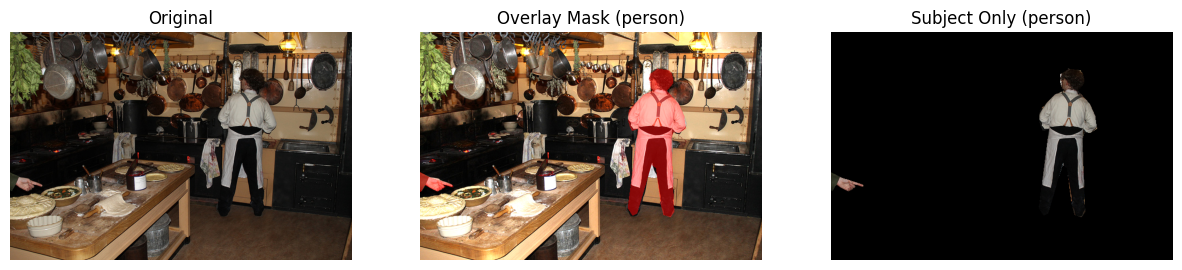

 No 'person' found in image: 000000037777.jpg


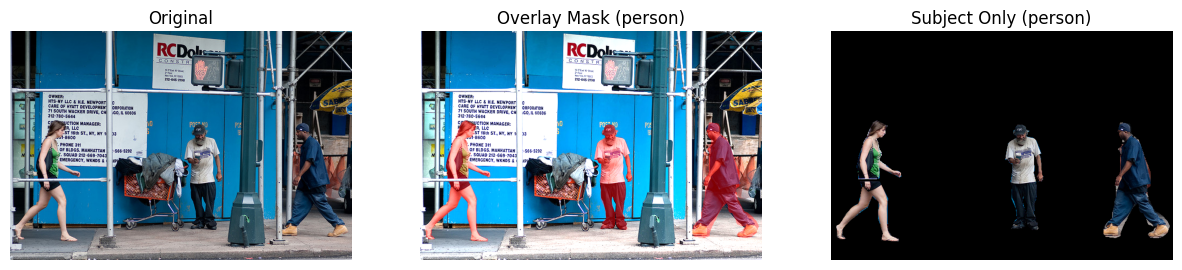

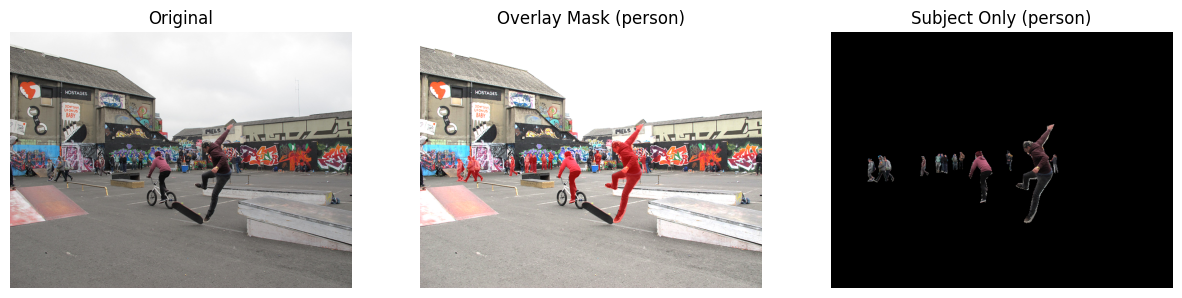

 No 'person' found in image: 000000174482.jpg


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

# ==== STEP 1: Setup Paths ====
ANN_FILE = "/content/drive/MyDrive/VisionAI/annotations/instances_val2017.json"
IMAGES_DIR = "/content/drive/MyDrive/VisionAI/val2017"
coco = COCO(ANN_FILE)

# ==== STEP 2: Pick main subject ====
main_subject_name = "person"   # change to 'dog', 'car', etc.
main_subject_cat_id = coco.getCatIds(catNms=[main_subject_name])[0]
print("Main subject:", main_subject_name, "| Category ID:", main_subject_cat_id)

# ==== STEP 3: Build binary mask for the chosen subject ====
def build_binary_mask_main_subject(coco, img_info, main_category_name="person"):
    cat_ids = coco.getCatIds(catNms=[main_category_name])
    ann_ids = coco.getAnnIds(imgIds=img_info['id'], catIds=cat_ids, iscrowd=False)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))

    return (mask > 0).astype(np.uint8)

# ==== STEP 4: Process multiple images ====
img_ids = coco.getImgIds()[:5]  # first 5 images

for img_id in img_ids:
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(IMAGES_DIR, img_info['file_name'])

    # Check image exists
    if not os.path.exists(img_path):
        print(f" Image not found: {img_path}")
        continue

    # Load image
    image = cv2.imread(img_path)
    if image is None:
        print(f" Failed to load image: {img_path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Build mask
    mask = build_binary_mask_main_subject(coco, img_info, main_category_name=main_subject_name)

    # Check mask is not empty
    if mask.sum() == 0:
        print(f" No '{main_subject_name}' found in image: {img_info['file_name']}")
        continue

    # 1. Overlay mask (red transparent)
    overlay = image.copy()
    overlay[mask == 1] = [255, 0, 0]
    alpha = 0.5
    overlayed = cv2.addWeighted(image, 1, overlay, alpha, 0)

    # 2. Subject only (keep original color, background black)
    subject_only = image.copy()
    subject_only[mask == 0] = 0

    # ==== Display Results ====
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(overlayed)
    plt.title(f"Overlay Mask ({main_subject_name})")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(subject_only)
    plt.title(f"Subject Only ({main_subject_name})")
    plt.axis("off")

    plt.show()


loading annotations into memory...
Done (t=4.48s)
creating index...
index created!
Total images available: 5000
Train samples: 4000
Val samples: 1000


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4191s 8s/step - accuracy: 0.7031 - loss: 0.6053 - val_accuracy: 0.7049 - val_loss: 0.5748
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 159ms/step - accuracy: 0.7094 - loss: 0.5629 - val_accuracy: 0.7234 - val_loss: 0.5389
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 159ms/step - accuracy: 0.7262 - loss: 0.5412 - val_accuracy: 0.7351 - val_loss: 0.5415
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 159ms/step - accuracy: 0.7361 - loss: 0.5276 - val_accuracy: 0.7253 - val_loss: 0.5313
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 158ms/step - accuracy: 0.7361 - loss: 0.5253 - val_accuracy: 0.7311 - val_loss: 0.5275
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 159ms/step - accuracy: 0.7388 - loss: 0.5248 - val_accuracy: 0.7541 - val_loss: 0.5023
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 159ms/step - accuracy: 0.7428 - loss: 0.5101 - val_accuracy: 0.7593 - val_loss: 0.4915
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 159ms/step - accuracy: 0.7528 - loss: 0.

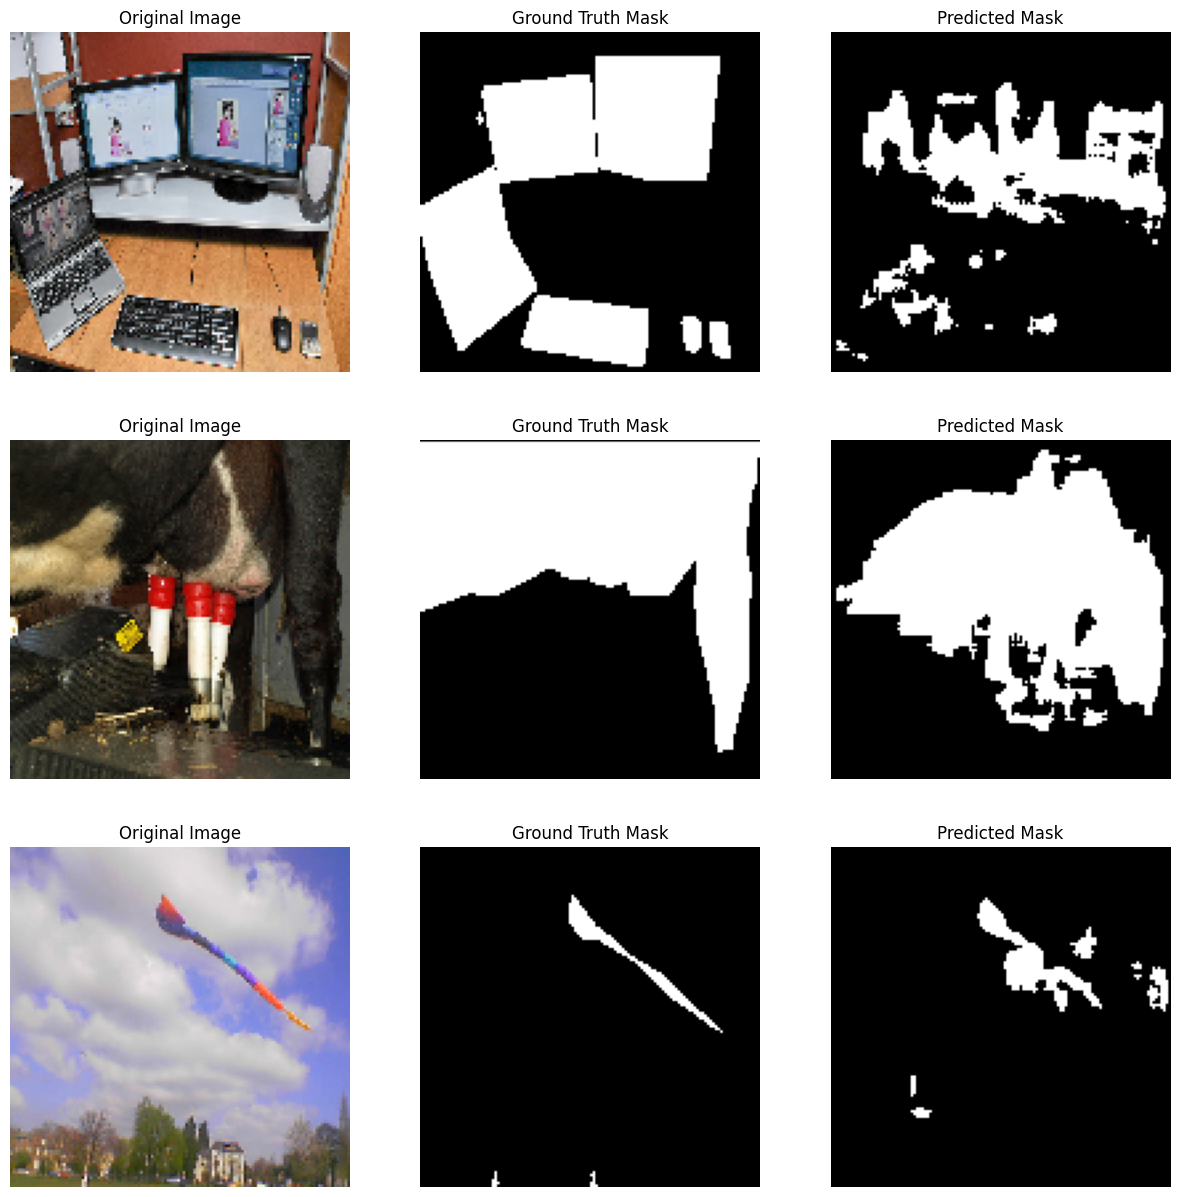

In [ ]:
# ==============================
# Week 3: Model Training + Evaluation
# ==============================

# -------------------- Imports --------------------
import os, random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -------------------- Paths --------------------
ANN_FILE = "/content/drive/MyDrive/VisionAI/annotations/instances_val2017.json"
IMG_DIR  = "/content/drive/MyDrive/VisionAI/val2017"

# -------------------- Load COCO --------------------
coco = COCO(ANN_FILE)
img_ids = coco.getImgIds()
print("Total images available:", len(img_ids))

# -------------------- Parameters --------------------
IMG_SIZE = 128
BATCH_SIZE = 8
EPOCHS = 20

# -------------------- Helper: create mask --------------------
def load_image_and_mask(img_id):
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(IMG_DIR, img_info["file_name"])

    # Read & resize image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0

    # Load annotations
    ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=False)
    anns = coco.loadAnns(ann_ids)

    # Create mask
    mask = np.zeros((img_info["height"], img_info["width"]), dtype=np.uint8)
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = np.expand_dims(mask, axis=-1)  # shape (128,128,1)

    return image, mask

# -------------------- Dataset Generator --------------------
class CocoDataset(keras.utils.Sequence):
    def __init__(self, img_ids, batch_size=BATCH_SIZE, augment=False):
        self.img_ids = img_ids
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.img_ids) / self.batch_size))

    def __getitem__(self, idx):
        batch_ids = self.img_ids[idx*self.batch_size:(idx+1)*self.batch_size]
        images, masks = [], []
        for img_id in batch_ids:
            img, mask = load_image_and_mask(img_id)

            # Optional augmentation
            if self.augment and random.random() > 0.5:
                img = np.fliplr(img)
                mask = np.fliplr(mask)

            images.append(img)
            masks.append(mask)
        return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

# -------------------- Split train/val --------------------
train_ids, val_ids = train_test_split(img_ids, test_size=0.2, random_state=42)
train_seq = CocoDataset(train_ids, augment=True)
val_seq   = CocoDataset(val_ids, augment=False)

print("Train samples:", len(train_ids))
print("Val samples:", len(val_ids))

# -------------------- Build U-Net --------------------
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

def encoder_block(x, filters):
    f = conv_block(x, filters)
    p = layers.MaxPooling2D((2, 2))(f)
    return f, p

def decoder_block(x, skip, filters):
    us = layers.Conv2DTranspose(filters, 2, strides=2, padding="same")(x)
    concat = layers.Concatenate()([us, skip])
    f = conv_block(concat, filters)
    return f

def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    f1, p1 = encoder_block(inputs, 64)
    f2, p2 = encoder_block(p1, 128)
    f3, p3 = encoder_block(p2, 256)
    f4, p4 = encoder_block(p3, 512)

    bottleneck = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(bottleneck, f4, 512)
    d2 = decoder_block(d1, f3, 256)
    d3 = decoder_block(d2, f2, 128)
    d4 = decoder_block(d3, f1, 64)

    outputs = layers.Conv2D(1, (1,1), activation="sigmoid")(d4)

    model = keras.Model(inputs, outputs, name="U-Net")
    return model

model = build_unet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# -------------------- Training --------------------
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]

history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=EPOCHS,
    callbacks=callbacks
)

# -------------------- Evaluation Metrics --------------------
def iou_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = (y_pred.flatten() > 0.5).astype(np.float32)
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = (y_pred.flatten() > 0.5).astype(np.float32)
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# Predict some samples
x_val, y_val = val_seq[0]
preds = model.predict(x_val)
preds_bin = (preds > 0.5).astype(np.float32)

# Metrics
iou = iou_coef(y_val, preds_bin)
dice = dice_coef(y_val, preds_bin)
pixel_acc = np.mean(y_val == preds_bin)

print(f"IoU: {iou:.4f}, Dice: {dice:.4f}, Pixel Acc: {pixel_acc:.4f}")

# -------------------- Visualization --------------------
n_samples = 3
plt.figure(figsize=(15, n_samples*5))
for i in range(n_samples):
    plt.subplot(n_samples, 3, i*3+1)
    plt.imshow(x_val[i])
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(n_samples, 3, i*3+2)
    plt.imshow(y_val[i].squeeze(), cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(n_samples, 3, i*3+3)
    plt.imshow(preds_bin[i].squeeze(), cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

plt.show()


In [ ]:
# ------------------- Metrics -------------------

def iou_coef(y_true, y_pred, smooth=1e-6):
    """Intersection over Union"""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coef(y_true, y_pred, smooth=1e-6):
    """Dice Coefficient"""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def pixel_accuracy(y_true, y_pred):
    """Pixel-wise Accuracy"""
    correct = np.sum(y_true == y_pred)
    total = y_true.size
    return correct / total

n_samples = min(len(y_val), len(preds_bin), 50)

y_true_eval = y_val[:n_samples]
y_pred_eval = preds_bin[:n_samples]

# Remove channel dim if present
if y_pred_eval.shape[-1] == 1:
    y_pred_eval = np.squeeze(y_pred_eval, axis=-1)

if y_true_eval.ndim == 4 and y_true_eval.shape[-1] == 1:
    y_true_eval = np.squeeze(y_true_eval, axis=-1)

# Compute metrics
iou = iou_coef(y_true_eval, y_pred_eval)
dice = dice_coef(y_true_eval, y_pred_eval)
pa = pixel_accuracy(y_true_eval, y_pred_eval)

print(f"IoU: {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"Pixel Accuracy: {pa:.4f}")



IoU: 0.3559
Dice Coefficient: 0.5250
Pixel Accuracy: 0.7124


loading annotations into memory...
Done (t=2.88s)
creating index...
index created!


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Epoch 1/5, Train Loss: 0.3542, Val Loss: 0.2402
Epoch 2/5, Train Loss: 0.2524, Val Loss: 0.2211
Epoch 3/5, Train Loss: 0.2211, Val Loss: 0.2166
Epoch 4/5, Train Loss: 0.2022, Val Loss: 0.2217
Epoch 5/5, Train Loss: 0.1888, Val Loss: 0.2124


Mean IoU: 0.6638, Mean Dice: 0.7882, Pixel Acc: 0.8694


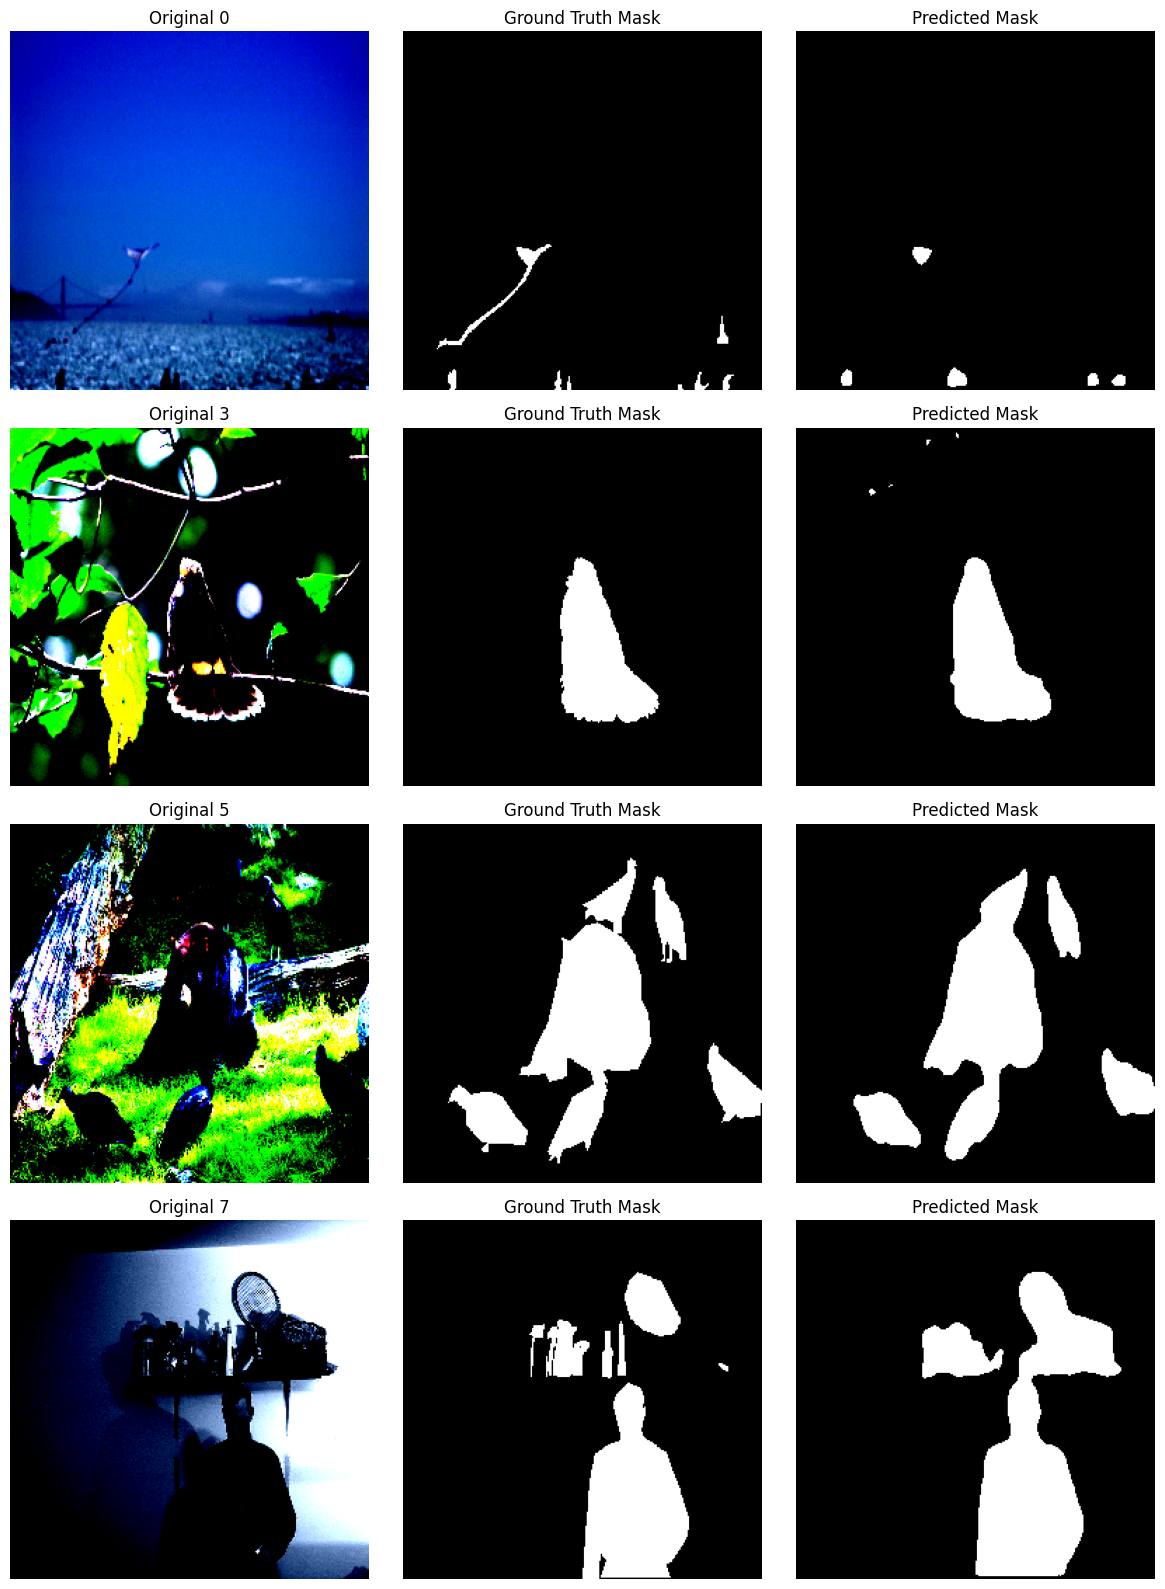

In [ ]:
# -------------------- WEEK 3 --U-Net with a pretrained EfficientNet-B4 --------------------
!pip install -q segmentation-models-pytorch
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

# -------------------- Paths --------------------
coco_img_dir = "/content/drive/MyDrive/VisionAI/val2017"   # path to COCO val images
coco_ann_file = "/content/drive/MyDrive/VisionAI/annotations/instances_val2017.json"  # annotations

# -------------------- Dataset --------------------
class COCOSegDataset(Dataset):
    def __init__(self, img_dir, ann_file, transform=None):
        self.coco = COCO(ann_file)
        self.img_dir = img_dir
        self.ids = list(self.coco.imgs.keys())
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        path = os.path.join(self.img_dir, img_info['file_name'])
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in anns:
            mask = np.maximum(mask, self.coco.annToMask(ann))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0).float()

        return image, mask

# -------------------- Transformations --------------------
train_tf = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
    ToTensorV2(),
])
val_tf = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2(),
])

# -------------------- Train / Val Split --------------------
dataset = COCOSegDataset(coco_img_dir, coco_ann_file, transform=train_tf)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

# -------------------- Model --------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = smp.Unet(
    encoder_name="efficientnet-b4",    # BEST pretrained backbone
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
).to(DEVICE)

loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# -------------------- Training --------------------
def train_model(model, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                outputs = model(images)
                loss = loss_fn(outputs, masks)
                val_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

train_model(model, train_loader, val_loader, epochs=5)

# -------------------- Metrics --------------------
def iou_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def dice_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def pixel_accuracy(pred, target):
    pred = (pred > 0.5).float()
    correct = (pred == target).float().sum()
    total = torch.numel(pred)
    return correct / total

# Evaluate on validation set
model.eval()
ious, dices, accs = [], [], []
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        outputs = torch.sigmoid(model(images))
        ious.append(iou_score(outputs, masks).item())
        dices.append(dice_score(outputs, masks).item())
        accs.append(pixel_accuracy(outputs, masks).item())
print(f"Mean IoU: {np.mean(ious):.4f}, Mean Dice: {np.mean(dices):.4f}, Pixel Acc: {np.mean(accs):.4f}")


# -------------------- Multi-sample Visualization --------------------
def visualize_predictions(model, dataset, indices=[0, 5, 10, 15]):
    model.eval()
    plt.figure(figsize=(12, len(indices) * 4))  # expand figure size for multiple rows

    for row, idx in enumerate(indices):
        image, mask = dataset[idx]
        image_input = image.unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            pred = torch.sigmoid(model(image_input)).squeeze().cpu().numpy()

        img_np = image.squeeze().cpu().permute(1, 2, 0).numpy()
        mask_np = mask.squeeze().cpu().numpy()
        pred_mask = (pred > 0.5).astype(np.uint8)

        # Original
        plt.subplot(len(indices), 3, row * 3 + 1)
        plt.imshow(img_np)
        plt.title(f"Original {idx}")
        plt.axis("off")

        # Ground Truth
        plt.subplot(len(indices), 3, row * 3 + 2)
        plt.imshow(mask_np, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Prediction
        plt.subplot(len(indices), 3, row * 3 + 3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Show 4 validation samples (you can change indices list)
visualize_predictions(model, val_dataset, indices=[0, 3, 5, 7])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.9 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


loading annotations into memory...
Done (t=2.82s)
creating index...
index created!
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Epoch 1/10, Train Loss: 0.3718, Val Loss: 0.2416
Epoch 2/10, Train Loss: 0.2828, Val Loss: 0.2197
Epoch 3/10, Train Loss: 0.2607, Val Loss: 0.2082
Epoch 4/10, Train Loss: 0.2410, Val Loss: 0.1996
Epoch 5/10, Train Loss: 0.2311, Val Loss: 0.1919
Epoch 6/10, Train Loss: 0.2210, Val Loss: 0.1862
Epoch 7/10, Train Loss: 0.2090, Val Loss: 0.1809
Epoch 8/10, Train Loss: 0.2009, Val Loss: 0.1796
Epoch 9/10, Train Loss: 0.2000, Val Loss: 0.1786
Epoch 10/10, Train Loss: 0.2003, Val Loss: 0.1775


Final Metrics → IoU: 0.7113, Dice: 0.8230, Pixel Acc: 0.8981


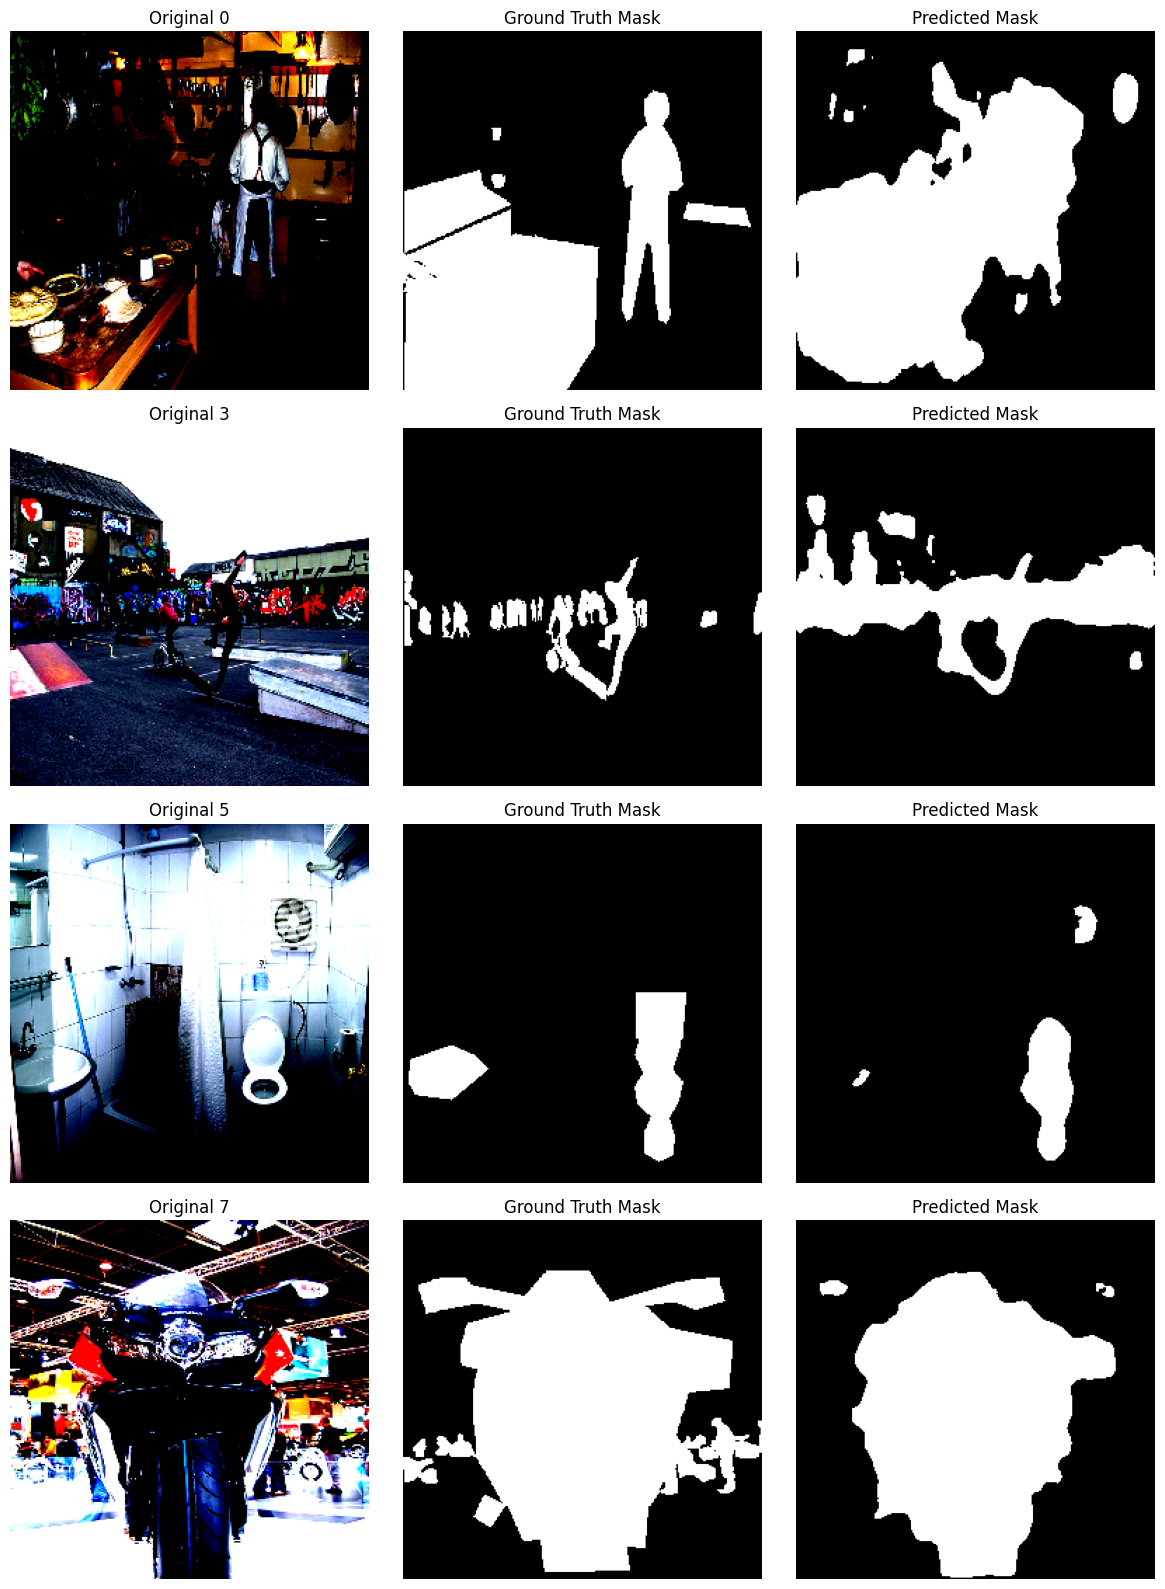

In [2]:
# -------------------- WEEK 4 --------------------
# Predictions & Fine-tuning
!pip install -q segmentation-models-pytorch
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

# -------------------- Paths --------------------
coco_img_dir = "/content/drive/MyDrive/VisionAI/val2017"   # COCO val images
coco_ann_file = "/content/drive/MyDrive/VisionAI/annotations/instances_val2017.json"

# -------------------- Dataset --------------------
class COCOSegDataset(Dataset):
    def __init__(self, img_dir, ann_file, transform=None):
        self.coco = COCO(ann_file)
        self.img_dir = img_dir
        self.ids = list(self.coco.imgs.keys())
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        path = os.path.join(self.img_dir, img_info['file_name'])
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in anns:
            mask = np.maximum(mask, self.coco.annToMask(ann))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0).float()

        return image, mask

# -------------------- Augmentations --------------------
train_tf = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Blur(p=0.2),
    A.Normalize(),
    ToTensorV2(),
])
val_tf = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2(),
])

# -------------------- Train / Val Split --------------------
dataset_full = COCOSegDataset(coco_img_dir, coco_ann_file, transform=train_tf)
val_dataset = COCOSegDataset(coco_img_dir, coco_ann_file, transform=val_tf)

train_size = int(0.8 * len(dataset_full))
val_size = len(dataset_full) - train_size
train_dataset, _ = torch.utils.data.random_split(dataset_full, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

# -------------------- Model --------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = smp.Unet(
    encoder_name="efficientnet-b4",    # High-performing pretrained encoder
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
).to(DEVICE)

loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# -------------------- Training --------------------
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                outputs = model(images)
                loss = loss_fn(outputs, masks)
                val_loss += loss.item()

        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

train_model(model, train_loader, val_loader, epochs=10)

# -------------------- Metrics --------------------
def iou_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def dice_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def pixel_accuracy(pred, target):
    pred = (pred > 0.5).float()
    correct = (pred == target).float().sum()
    total = torch.numel(pred)
    return correct / total

# Evaluate on validation set
model.eval()
ious, dices, accs = [], [], []
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        outputs = torch.sigmoid(model(images))
        ious.append(iou_score(outputs, masks).item())
        dices.append(dice_score(outputs, masks).item())
        accs.append(pixel_accuracy(outputs, masks).item())
print(f"Final Metrics → IoU: {np.mean(ious):.4f}, Dice: {np.mean(dices):.4f}, Pixel Acc: {np.mean(accs):.4f}")

# -------------------- Multi-sample Visualization --------------------
def visualize_predictions(model, dataset, indices=[0, 3, 5, 7]):
    model.eval()
    plt.figure(figsize=(12, len(indices) * 4))

    for row, idx in enumerate(indices):
        image, mask = dataset[idx]
        image_input = image.unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            pred = torch.sigmoid(model(image_input)).squeeze().cpu().numpy()

        img_np = image.squeeze().cpu().permute(1, 2, 0).numpy()
        mask_np = mask.squeeze().cpu().numpy()
        pred_mask = (pred > 0.5).astype(np.uint8)

        # Original
        plt.subplot(len(indices), 3, row * 3 + 1)
        plt.imshow(img_np)
        plt.title(f"Original {idx}")
        plt.axis("off")

        # Ground Truth
        plt.subplot(len(indices), 3, row * 3 + 2)
        plt.imshow(mask_np, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Prediction
        plt.subplot(len(indices), 3, row * 3 + 3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_dataset, indices=[0, 3, 5, 7])


In [3]:
save_path = "/content/drive/MyDrive/VisionAI/best_model.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved at {save_path}")


Model saved at /content/drive/MyDrive/VisionAI/best_model.pth


In [5]:
# Define the model exactly the same way as before
model = smp.Unet(
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",  # only for initialization
    in_channels=3,
    classes=1,
).to(DEVICE)

# Load saved weights
load_path = "/content/drive/MyDrive/VisionAI/best_model.pth"
model.load_state_dict(torch.load(load_path, map_location=DEVICE))
model.eval()

print("✅ Model loaded successfully, ready for predictions!")


✅ Model loaded successfully, ready for predictions!
